In [2]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64

In [3]:

from data.dataset import GDMDataset
from torchvision import transforms
from torch.utils.data import DataLoader 

transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

train_dataset = GDMDataset("../gas-distribution-datasets/synthetic/train/train90.pt", mode="train", split_ratio=0.8, transform=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = GDMDataset("../gas-distribution-datasets/synthetic/train/train90.pt", mode="val", split_ratio=0.8, transform=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]/home/nwinkler/miniforge3/envs/neuralop0.3/lib/python3.10/site-packages/tltorch/factorized_tensors/factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  return self.__class__(self.tensor[indices])
/home/nwinkler/miniforge3/envs/neuralop0.3/lib/python3.10/site-packages/neuralop/layers/spectral_convolution.py:459: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an erro

Text(0, 0.5, 'Loss')

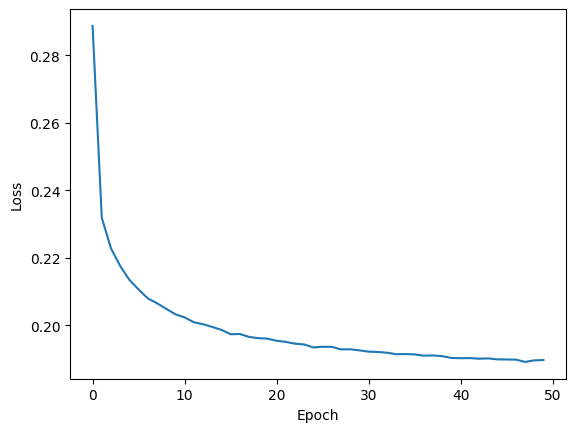

In [8]:
from neuralop.models import FNO
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

model = FNO(n_modes=(16, 16),
             in_channels=2,
             out_channels=1,
             hidden_channels=32,
             projection_channel_ratio=2)
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
best_loss = float('inf')

EPOCHS = 50

all_train_losses = []
all_val_losses = []

for epoch in tqdm(range(EPOCHS), desc="Training Progress", position=0):

    epoch_losses = []
    loop = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{EPOCHS}]", position=1, leave=False)

    for batch in loop:
        X, y = batch
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        pred = model(X)
        loss = F.mse_loss(pred, y)
        
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        loop.set_postfix(loss=loss.item())

    all_train_losses.append(sum(epoch_losses) / len(epoch_losses))

plt.plot(all_train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [9]:
torch.save(model.state_dict(), 'fno_model.pth')